*CNN with sequential GloVe embeddings*

This notebook performs classification on the Twitter Sentiment140 dataset with ~1.6 milllions tweets. We use Stanford's pretrained [GloVe embedding ](https://nlp.stanford.edu/projects/glove/) to format our data and classify with a Convolutional Neural Network (CNN)

In [5]:
!curl -LO http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   270  100   270    0     0     46      0  0:00:05  0:00:05 --:--:--    63
100 77.5M  100 77.5M    0     0  7209k      0  0:00:11  0:00:11 --:--:-- 19.6M


In [6]:
!unzip trainingandtestdata.zip

Archive:  trainingandtestdata.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.1600000.processed.noemoticon.csv  


In [7]:
!curl -LO http://nlp.stanford.edu/data/wordvecs/glove.twitter.27B.zip
!unzip glove.twitter.27B.zip
!rm glove.twitter.27B.zip trainingandtestdata.zip
!rm glove.twitter.27B.100d.txt glove.twitter.27B.50d.txt glove.twitter.27B.25d.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0   326    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0   363    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1449M  100 1449M    0     0  2107k      0  0:11:44  0:11:44 --:--:-- 2037k
Archive:  glove.twitter.27B.zip
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  


In [21]:
%load_ext autoreload
%autoreload 2
from data_preprocessing import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
# load GloVe embeddings
word2vectors, word2id = load_GloVe_twitter_emb()
# load the twitter dataset and splits in train/val/test
train, val, test = load_twitter_datasets(n_train=25000, n_val=8000)

In [23]:
tweets = train.tweet.apply(glove_preprocess).apply(normalize_text).values
# original tweets
train.tweet.values[:25]

array(["One-fifth of the world's population can't see the Milky Way  http://is.gd/12DHj Come to think of it, I don't know if I've ever seen it ",
       "Quadcam doesn't work on 3Gs!!! ",
       '@Fearnecotton hey ferne, you Okay? hows it gOingggg? write back ',
       "@NileyLover09 watching a video of Demi's speech about this girl that has this disease.... its so sad i almost tears up ",
       "I think Nick and I are going to see Up tomorrow. I can't wait. I really enjoy being around him ",
       'Just missed his babies so much today ',
       '@JimmyVo well now my week is full  maybe next week? btw, go accept me on lastfm ya jerk lol',
       '@gellivictor Hi gelli! You finally got twitter yay! ',
       'OK, I give up on getting a Timbuk2 bag in Austria ',
       'I hate that, because of spam protection, I have to &quot;get email working&quot; with some people. ',
       '@rachmurrayX lolz ;) i need to get money, have none atm. if i can get some we should go on monday ',
       "

In [24]:
# after preprocessing
tweets[:25]

array(['one fifth of the world is population can not see the milky way <elong> <url> come to think of it i do not know if i have ever seen it',
       'quadcam does not work on <number> gs',
       '<user> hey ferne you okay hows it going <elong> write back',
       '<user> watching a video of demi is speech about this girl that has this disease its so sad i almost tears up',
       'i think nick and i are going to see up tomorrow i can not wait i really enjoy being around him',
       'just missed his babies so much today',
       '<user> well now my week is full maybe next week btw go accept me on lastfm ya jerk lol',
       '<user> hi gelli you finally got twitter yay',
       'ok <allcaps> <elong> i give up on getting a timbuk <number> bag in austria',
       'i hate that because of spam protection i have to quot get email working quot with some people',
       '<user> lolz <smile> i need to get money have none atm if i can get some we should go on monday',
       'i just had to wa

In [25]:
Xtrain, Ytrain = processAllTweets2vec(train, word2vectors)
Xval, Yval = processAllTweets2vec(val, word2vectors)
Xtest, Ytest = processAllTweets2vec(test, word2vectors)
Xtrain.shape, Ytrain.shape

((25000, 200), (25000, 1))

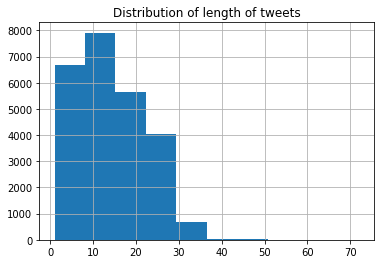

In [26]:
# look into distribution of length of tweets to determine optimal padding
import matplotlib.pyplot as plt
train.tweet.apply(glove_preprocess).apply(normalize_text).apply(lambda x: len(x.split(' '))).hist()
plt.title('Distribution of length of tweets')
plt.show()

Create embedding matrix

In [27]:
vocab = extractVocabulary(train)
restrictedWord2id, embMatrix = vocabEmbeddings(vocab, word2vectors)

100%|██████████| 25000/25000 [00:09<00:00, 2659.23it/s]


In [28]:
embMatrix.shape

(13112, 200)

Process all data to tokens in matrix format to train CNN with

In [0]:
Xtrain, Ytrain = processAllTweets2tok(train, restrictedWord2id)
Xval, Yval = processAllTweets2tok(val, restrictedWord2id)
Xtest, Ytest = processAllTweets2tok(test, restrictedWord2id)

In [30]:
Xtrain.shape, Ytrain.shape

((25000, 40), (25000, 1))

Create PyTorch DataLoader

In [0]:
import torch
from utils import *
import torch.utils.data as td
# create Tensor datasets
train_data = td.TensorDataset(convertToTorchInt(Xtrain), convertToTorchFloat(Ytrain))
val_data = td.TensorDataset(convertToTorchInt(Xval), convertToTorchFloat(Yval))
test_data = td.TensorDataset(convertToTorchInt(Xtest), convertToTorchFloat(Ytest))

# dataloaders
batch_size = 128

# make sure to SHUFFLE your data
train_loader = td.DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = td.DataLoader(val_data, shuffle=True, batch_size=batch_size)
test_loader = td.DataLoader(test_data, shuffle=True, batch_size=batch_size)

Create our CNN model

In [39]:
from models import NetCNN
cnn = NetCNN(vocab_size=embMatrix.shape[0], embedding_matrix=embMatrix, 
             filter_sizes=[1, 2, 3, 5, 10], num_filters=8, embed_size=embMatrix.shape[1], 
             finetune_emb=False, epochs=150, learning_rate=2e-5, l2reg=3e-3, dropout=0.1)

cnn = cnn.cuda() if torch.cuda.is_available() else cnn
print (cnn)
print (sum([np.prod(p.size()) for p in cnn.parameters()])-np.prod(embMatrix.shape))

NetCNN(
  (embedding): Embedding(13112, 200)
  (convs1): ModuleList(
    (0): Conv2d(1, 8, kernel_size=(1, 200), stride=(1, 1))
    (1): Conv2d(1, 8, kernel_size=(2, 200), stride=(1, 1))
    (2): Conv2d(1, 8, kernel_size=(3, 200), stride=(1, 1))
    (3): Conv2d(1, 8, kernel_size=(5, 200), stride=(1, 1))
    (4): Conv2d(1, 8, kernel_size=(10, 200), stride=(1, 1))
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=40, out_features=1, bias=True)
  (finalActivation): Sigmoid()
  (criterion): BCELoss()
)
33681


Train CNN

In [40]:
history = cnn.fit(train_loader, val_loader)
test_performance = cnn.evaluate_loader(test_loader)
print ("Test performance: loss={:.3f}, accuracy={:.3f}, precision={:.3f}, recall={:.3f}, f1={:.3f}".format(*[ test_performance[m] for m in ['loss', 'accuracy', 'precision', 'recall', 'f1']]))

Epoch 1/150
Train performance: loss=0.692, accuracy=0.524, precision=0.515, recall=0.906, f1=0.653
Val   performance: loss=0.683, accuracy=0.567, precision=0.565, recall=0.719, f1=0.632
Epoch 6/150
Train performance: loss=0.643, accuracy=0.670, precision=0.683, recall=0.635, f1=0.656
Val   performance: loss=0.642, accuracy=0.658, precision=0.675, recall=0.656, f1=0.664
Epoch 11/150
Train performance: loss=0.602, accuracy=0.697, precision=0.702, recall=0.683, f1=0.690
Val   performance: loss=0.604, accuracy=0.692, precision=0.708, recall=0.694, f1=0.699
Epoch 16/150
Train performance: loss=0.572, accuracy=0.718, precision=0.716, recall=0.721, f1=0.717
Val   performance: loss=0.580, accuracy=0.704, precision=0.724, recall=0.695, f1=0.707
Epoch 21/150
Train performance: loss=0.551, accuracy=0.733, precision=0.734, recall=0.729, f1=0.730
Val   performance: loss=0.560, accuracy=0.720, precision=0.731, recall=0.728, f1=0.728
Epoch 26/150
Train performance: loss=0.532, accuracy=0.746, precisi

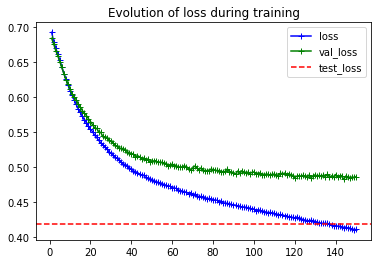

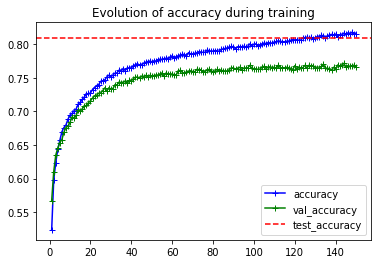

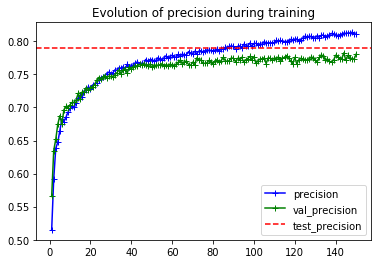

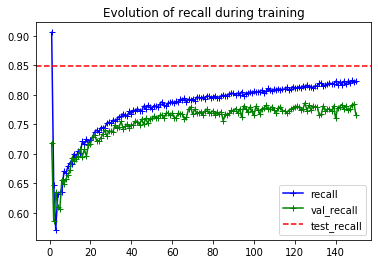

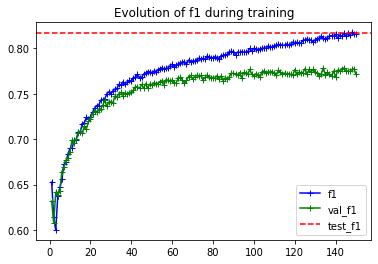

In [41]:
plot_perf(history, test_performance)

Code credit to [EsterHlav](https://github.com/EsterHlav)'s GitHub [repo](https://GloVe_Sentiment_Analysis_MLP_CNN_TwitterSentiment140
) 